![Py4Eng](img/logo.png)

# Numba: just-in-time compilation for numerical computation
## Yoav Ram

# Numba

[Numba]((http://numba.pydata.org) speeds functions written directly in Python. 
With a few annotations, array-oriented and math-heavy Python code can be *just-in-time* (JIT) compiled to native machine instructions, similar in performance to C, C++ and Fortran, without having to switch languages or Python interpreters.

Roughly, [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation) compilation combines the speed of compiled code with the flexibility of interpretation, with the overhead of an interpreter and the additional overhead of compiling (not just interpreting).

Numba also allows to release the GIL, thus allowing multithreading in CPU-bounded applications. 
It also allows to automatically parallelize code.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numba
print('Numba', numba.__version__, "with NumPy", np.__version__)
import Cython
%load_ext Cython

Numba 0.61.0 with NumPy 2.1.3


# Mandelbrot fractal

We start with Mandelbrot's fractal, which we already saw in the [Cython](cython.ipynb) session.

In [2]:
def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

CPU times: user 639 ms, sys: 4.24 ms, total: 643 ms
Wall time: 642 ms


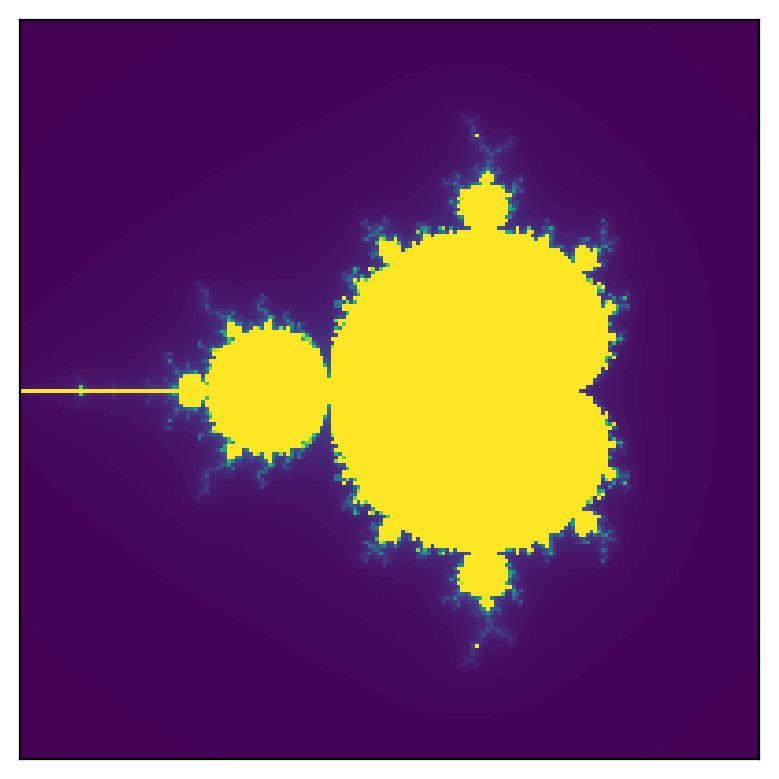

In [3]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)

%time mandelbrot(m, size, iterations)
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

Now we can use Numba to just-in-time compile `mandelbrot` using `njit`.

In [4]:
nmandelbrot = numba.njit(mandelbrot)
nmandelbrot(m, size, iterations); # run once for jit to work

In [5]:
%timeit mandelbrot(m, size, iterations)
%timeit nmandelbrot(m, size, iterations)

603 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.87 ms ± 25 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Without any new code, just by calling `njit`, we get a ~200-fold improvement, similar to the Cython version.

Let's compare it directly to the Cython version on a harder to compute version of Mandelbrot's fractal.

Remember: Cython requires extra coding of type defs and removal of `np.abs` and build-time compilation, both of which are not required by Numba.

In [6]:
%%cython
def cmandelbrot(int[:,:] m, int size, int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real*z.real + z.imag*z.imag <= 100:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [7]:
size = 1000
iterations = 1000
m = np.zeros((size, size), dtype=np.int32)

%timeit cmandelbrot(m, size, iterations)
%timeit nmandelbrot(m, size, iterations)

386 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
750 ms ± 5.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that Numba is on par with Cython, with a 1.5-fold slower runtime.

# Parallelization
Numba code can be parallelized automatically using [multi-threading](https://numba.readthedocs.io/en/stable/user/parallel.html) on multi-core machines. 
This can be implemented easily with `numba.prange` instead of `range` and by adding `parallel=True` to `njit`.
Although this can be accomplished in Cython using `cython.parallel.prange`, it's harder to accomplish because the compiler needs to be installed with OpenMP support. With Numba, this is already taken cared of when Numba is installed with conda/mamba/pip.

In [9]:
@numba.njit(parallel=True)
def pmandelbrot(m, size, iterations):
    for i in numba.prange(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
pmandelbrot(m, size, iterations); # burn-in

In [10]:
%timeit pmandelbrot(m, size, iterations)

192 ms ± 797 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


So now we have improved over the non-parallel by about 4-fold on a machine with eight cores, and we beat Cython (which used a non-parallel implementation).

# Exercise: Parallel loop

Consider the following NumPy function which calculates the mean squared error of two arrays with the same length.

In [11]:
n = 100000
x = np.random.random(n)
y = np.random.random(n)

In [12]:
def mse_np(x, y):
    return ((x - y)**2).mean()

mse_np(x, y)

np.float64(0.16756518997768496)

Try to make it faster with Numba! Write it as a pure-Python function (no NumPy tricks) and jit it. Consider parallelization. You can assume `x` and `y` are 1D arrays of the same length.

In [29]:
%timeit mse_np(x, y)
%timeit mse_nm(x, y)

115 μs ± 903 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.2 μs ± 718 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Image segmentation

Let's do another example in which we segment images - turn a grayscale image into a binary image.


In [2]:
import imageio
from skimage.transform import resize

def display_image(im):
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

Let's do a segmentation demonstration.

(dtype('float64'), (900, 944), np.float64(0.0), np.float64(255.0))

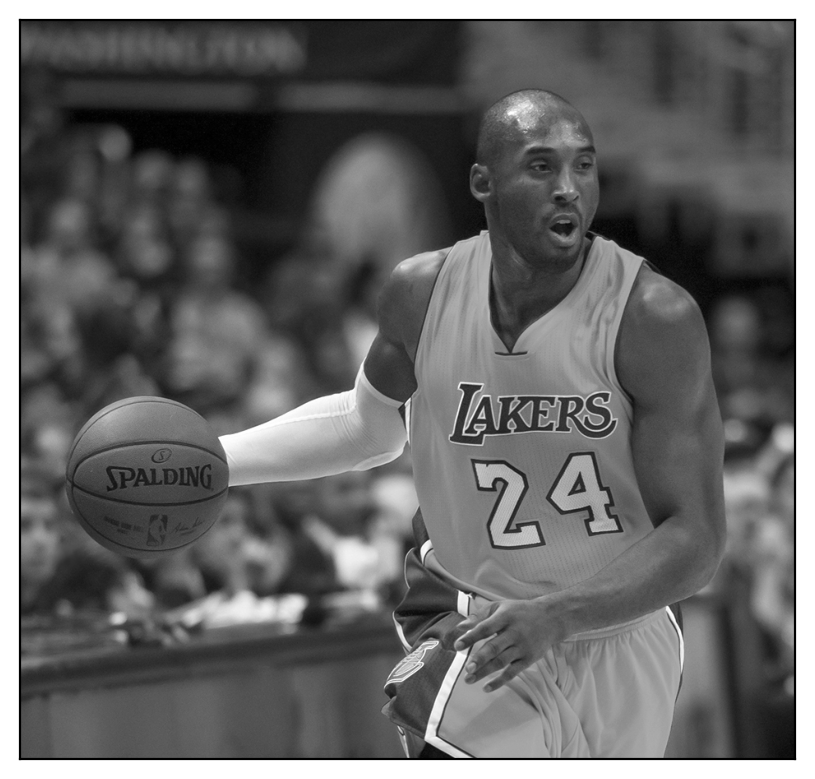

In [14]:
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
image = imageio.v2.imread('../data/Kobe_Bryant_2014.jpg')
image = image.mean(axis=2) # greyscale
display_image(image)
image.dtype, image.shape, image.min(), image.max()

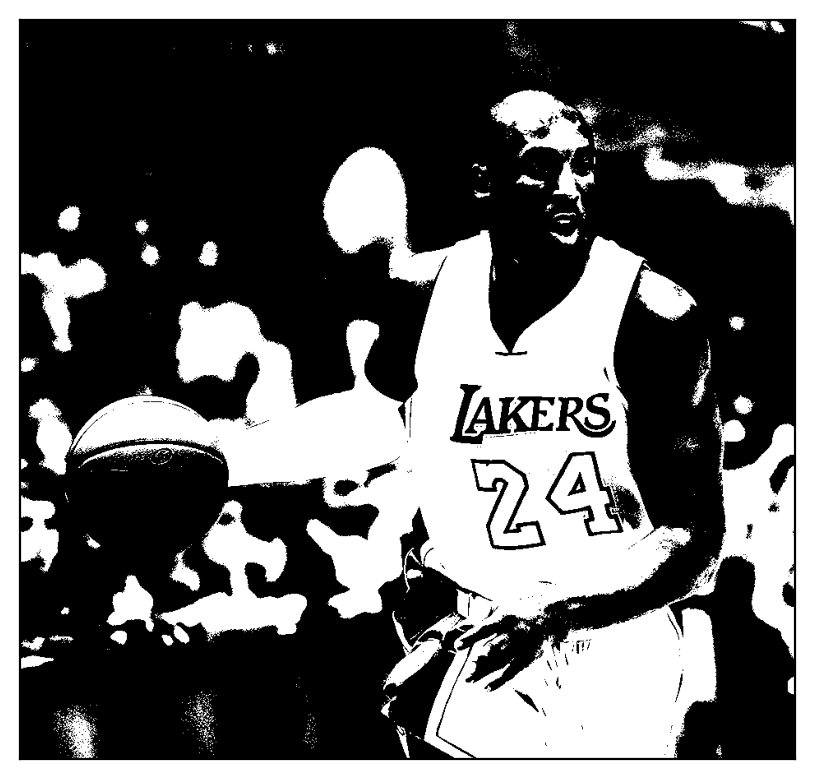

In [15]:
def segment(image, threshold=100):
    output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

display_image(segment(image))

In our Numba version, we only need a single function that creates the output array and uses loops to segment the input into the output (we don't need two separate functions as we did with Cython).

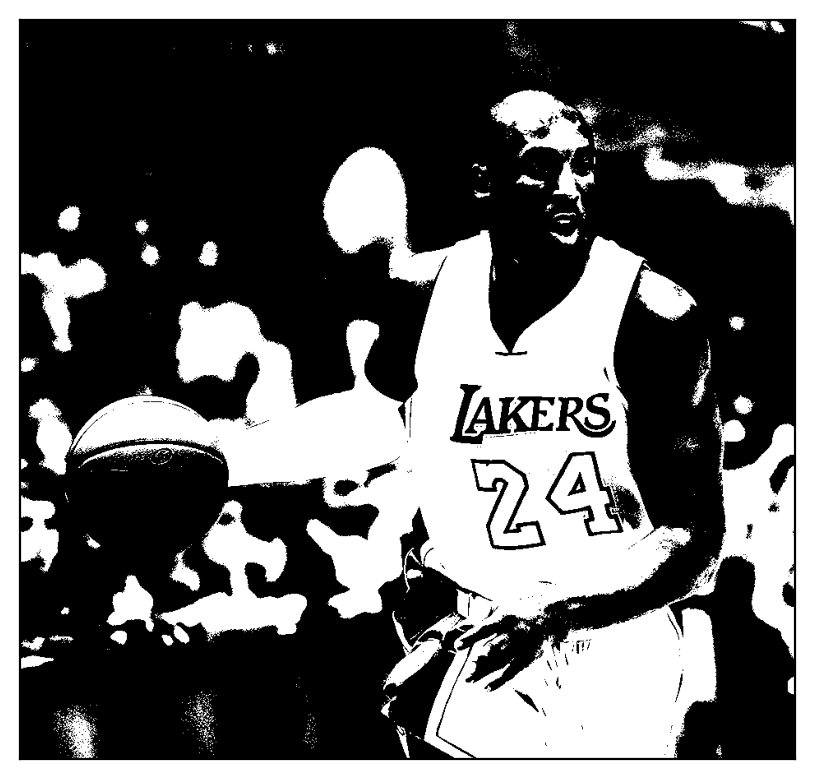

In [30]:
@numba.njit
def nsegment(image, threshold=100):
    output = np.empty_like(image)
    n, m = image.shape
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0
    return output

display_image(nsegment(image))

In [31]:
%timeit -n 10 -r 5 segment(image)
%timeit -n 10 -r 5 nsegment(image)

987 μs ± 477 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)
182 μs ± 4.28 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


So on a single image Numba is even faster than Cython, which came at 333 μs.

Let's download the 30 examples images from the [Berkeley Segmentation Dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/test-001-025.html).

![example](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg)

In [3]:
image_urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/{:d}.jpg'.format(i)
    for i in [119082,170057,58060,163085,42049,167062,157055,295087,24077,78004,220075,45096,38092,43074,16077,86000,101085,219090,89072,300091,126007,156065,76053,296007,175032]
]
image_urls[0]

'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/119082.jpg'

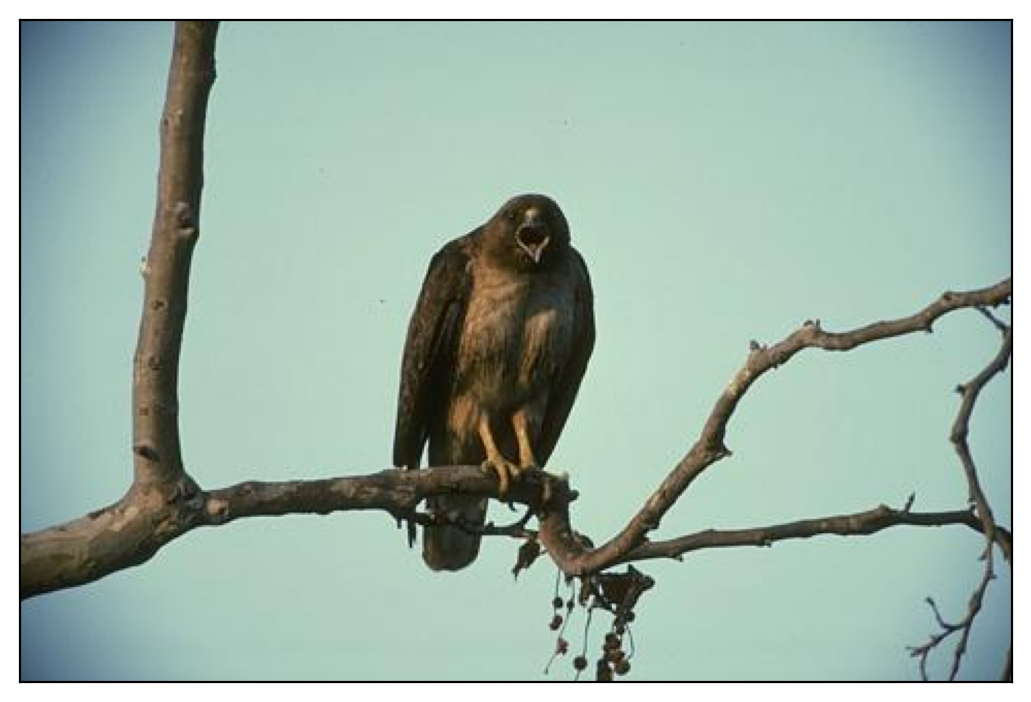

In [4]:
display_image(imageio.v2.imread(image_urls[4]))

Load and flatten the images:

In [5]:
images = [imageio.v2.imread(url) for url in image_urls]
images = [im.mean(axis=2) for im in images]

First compare the NumPy and Numba versions:

In [46]:
%timeit -n 10 -r 5 [segment(im) for im in images];
%timeit -n 10 -r 5 [nsegment(im) for im in images];

4.25 ms ± 1.27 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
685 μs ± 8.77 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


Again, nice improvement and even better than Cython.


# Numba stencils (local filters)

Numba's `stencil` decorator works similar to SciPy's `generic_filter`, but uses the JIT capabilities of Numba.

Let's start by adding some noise to the images:

In [6]:
def salt_pepper(image, p=0.01):
    """Generates salt and pepper noise.
    
    Each pixel is "hit" independently with probability `p`. 
    If hit, a pixel has 1:1 chance of becoming white or black.
    """
    noisy = image.copy()
    rand = np.random.random(size=noisy.shape)
    mask_black = rand <= p/2
    noisy[mask_black] = 0
    mask_white = (p/2 < rand) & (rand <= p)
    noisy[mask_white] = 255
    return noisy

In [7]:
noisy = [salt_pepper(im, p=0.25) for im in images]

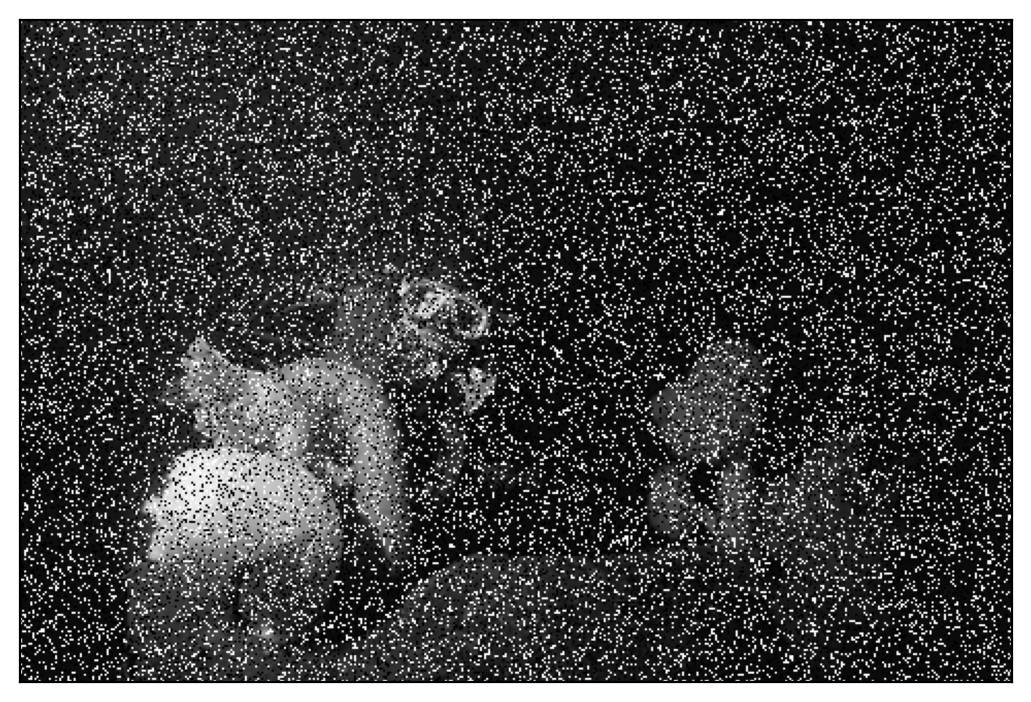

In [8]:
display_image(noisy[11])

Now let's clean the images with a bounded mean filter.
Start with a SciPy version, which uses [`generic_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html), a function that applies a local filter across an array.

`k` is the kernel size.

In [9]:
from scipy.ndimage import generic_filter

def local_bounded_mean_scipy(image, black_th=5, white_th=250, k=5):
    def filter(neighbours):
        center = neighbours.size // 2
        center_pixel = neighbours[center]
        if not black_th < center_pixel < white_th: # center_pixel is noisy
            mask = (black_th <= neighbours) & (neighbours <= white_th) # grab only non-noisy neighbors
            if mask.any():
                return neighbours[mask].mean()
        # either center was not extreme or all its neighbors are extreme
        return center_pixel

    return generic_filter(image, filter, size=(2*k+1, 2*k+1))

Now we implement a Numba version.
We write a `filter` function that accepts a 2D neighborhood, the dimensions of which can be specified in the `stencil` directive, and returns the stencil or local filter result.
The `stencil` decorator does the rest.

In [10]:
def local_bounded_mean_numba(image, black_th=5, white_th=250, k=5):    
    @numba.stencil(neighborhood=((-k, k), (-k, k)))
    def filter(neighbours):
        center_pixel = neighbours[0,0]
        if not black_th < center_pixel < white_th: # center_pixel is noisy
            summ, count = 0, 0 
            for i in range(-k, k+1):
                for j in range(-k, k+1):
                    pixel = neighbours[i,j]
                    if black_th <= pixel <= white_th: # neighbor pixel is not noisy
                        summ += pixel
                        count += 1
            if count > 0:
                return summ / count
        # either center was not extreme or all its neighbors are extreme
        return center_pixel
    
    return filter(image)

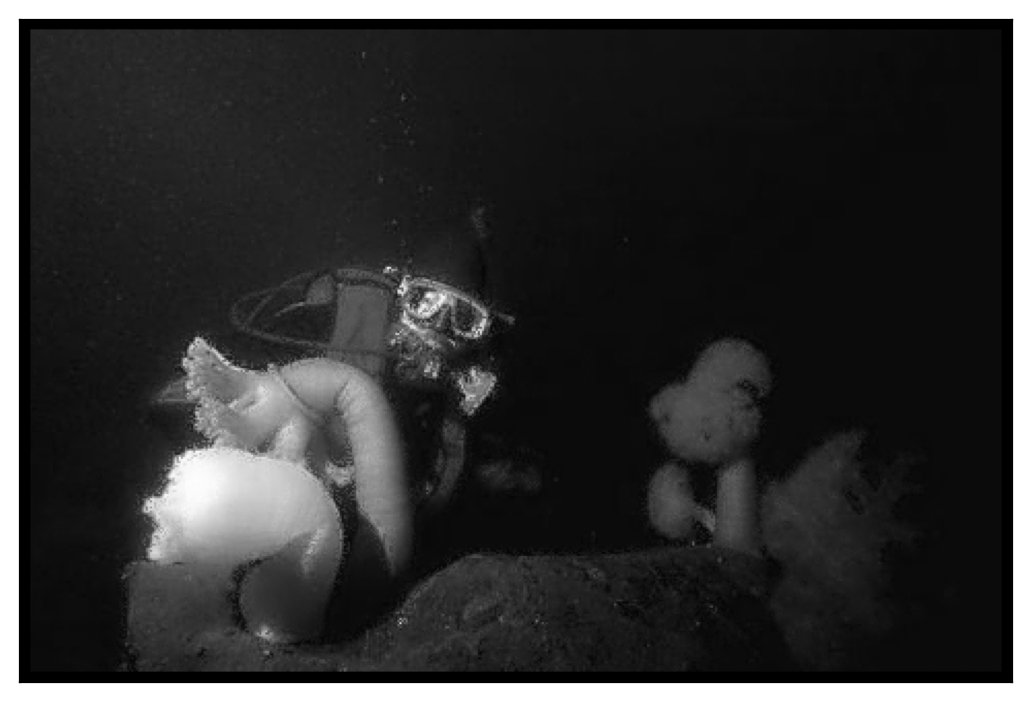

In [11]:
denoised = local_bounded_mean_numba(noisy[11])
display_image(denoised)

In [61]:
%timeit -n 10 -r 5 local_bounded_mean_numba(noisy[0])
%timeit -n 10 -r 5 local_bounded_mean_scipy(noisy[0])

170 ms ± 2.64 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
855 ms ± 15.1 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


Nice improvement with Numba.

# Monte Carlo: Estimating $\pi$ with sampling 

Next, we will implement a Monte Carlo approach to integration.

We estimate the value of $\pi$ by sampling random points in the unit square.
The fraction of points that fall within the unit circle multiplied by 4 approximates $\pi$.


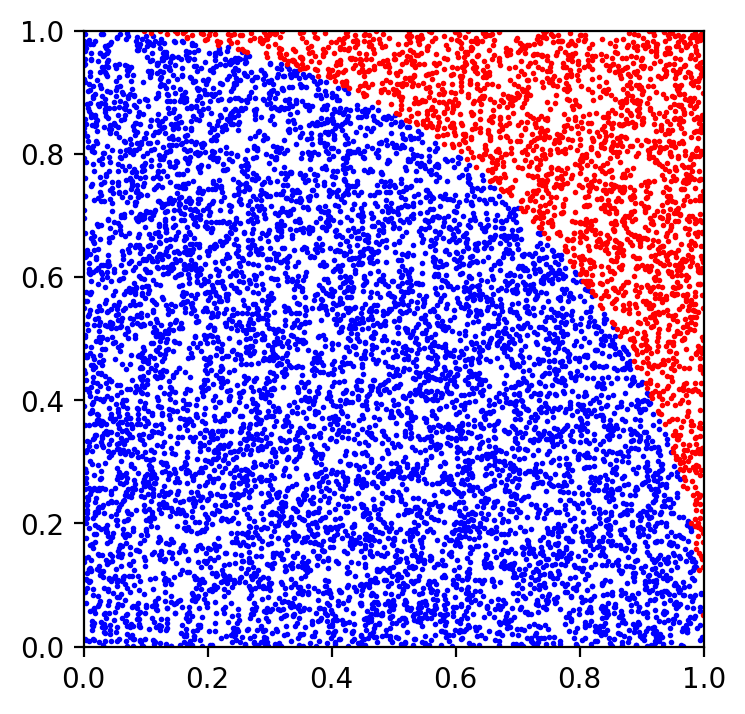

In [125]:
n = 10000
x, y = np.random.random((2, n))
accept = x*x + y*y < 1
π = accept.mean()*4
plt.figure(figsize=(4,4))
plt.scatter(x[accept], y[accept], color='b', s=1)
plt.scatter(x[~accept], y[~accept], color='r', s=1)
plt.xlim(0, 1)
plt.ylim(0, 1);

Write in a function and test time:

In [126]:
def estimate_π(n):
    x, y = np.random.random((2, n))
    accept = x*x + y*y < 1
    return accept.mean()*4, x, y, accept

In [127]:
n = 1000000
%timeit -n 10 -r 5 estimate_π(n)

10.6 ms ± 1.33 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


We now implement a pure Python version.

In [128]:
def estimate_π(n):
    accept = 0
    for i in range(n):
        x, y = np.random.random(), np.random.random()
        accept += x*x + y*y < 1
    return accept/n * 4

In [129]:
%timeit -n 10 -r 5 estimate_π(n)

593 ms ± 6.24 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


If we jit-compile this pure Python implementation, we get something better.

In [130]:
estimate_π = numba.njit(estimate_π)
estimate_π(100)
%timeit -n 10 -r 5 estimate_π(n)

4.11 ms ± 65.6 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


We can instead jit-compile the NumPy version.

In [131]:
@numba.njit
def estimate_π(n):
    x, y = np.random.random((2, n))
    accept = x*x + y*y < 1
    return accept.mean()*4

estimate_π(100)
%timeit -n 10 -r 5 estimate_π(n)

5.51 ms ± 41.7 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


It's not as good as the compiled pure Python version.

## Exercise

Use `njit(parallel=True)` on the pure-Python and the NumPy implementations to test if they improve and by how much.

123 μs ± 9.84 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


141 μs ± 9.86 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)